#Membuat CNN(Convolutional Neural Network) untuk mengenali bentuk tangan yang membentuk PAPER ROCK dan SCISSOR
Nama : Fajrinna Kasih Suci | Email Dicoding : fajrinnaks@gmail.com | Kelas : Machine Learning untuk pemula

##**1. Mempersiapkan Data**

In [1]:
#import library untuk proses ekstraksi serta mengatur lokasi file
import os
from zipfile import ZipFile

#import library untuk proses machine learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

#import library untuk mengunggah file kedalam google colabs
import numpy as np
from google.colab import files
from keras.preprocessing import image

#import library untuk membuat plot grafik akurasi dan loss-function
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
#mendownload dataset yang digunakan 
!wget https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip

--2021-07-10 14:23:34--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘rockpaperscissors.zip’

rockpaperscissors.z 100%[===================>] 307.92M  2.25MB/s    in 85s     

2021-07-10 14:25:01 (3.61 MB/s) - ‘rockpaperscissors.zip’ saved [322873683/322873683]



In [4]:
#ekstrak dataset yang berformat zip
from zipfile import ZipFile
zf = ZipFile('rockpaperscissors.zip', 'r')
zf.extractall('/dataset')
zf.close()

In [5]:
#mengatur lokasi file paper, rock, dan scissor
dir_dataset = "/dataset/rockpaperscissors/rps-cv-images"
dir_paper = os.path.join("/dataset/rockpaperscissors/rps-cv-images/paper")
dir_rock = os.path.join("/dataset/rockpaperscissors/rps-cv-images/rock")
dir_scissors = os.path.join("/dataset/rockpaperscissors/rps-cv-images/scissors")

In [6]:
# melihat direktori yang ada dalam dataset
os.listdir(dir_dataset)

['rock', 'paper', 'README_rpc-cv-images.txt', 'scissors']

In [7]:
# melihat berapa banyak data pada setiap direktori
print('total gambar kertas :', len(os.listdir(dir_paper)))
print('total gambar batu :', len(os.listdir(dir_rock)))
print('total gambar gunting :', len(os.listdir(dir_scissors)))

total gambar kertas : 712
total gambar batu : 726
total gambar gunting : 750


## **2. Pre-processing data dengan image augmentation**

In [8]:
# membuat sebuah objek ImageDataGenerator untuk data training dan data testing
# Ukuran validation set harus 40% maka validation_split = 0.4

Train_DataGen = ImageDataGenerator(
    rotation_range = 20,
    shear_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = 0.4  
)

Validation_DataGen = ImageDataGenerator(
    rotation_range = 20,
    shear_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = 0.4)

In [9]:
#mempersiapkan data latih yang akan dipelajari oleh model

Train_Generator = Train_DataGen.flow_from_directory(
        dir_dataset,  # direktori data latih
        target_size=(150,150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=32, 
        class_mode='categorical',
        subset='training') # masukkan Train_Generator sbg data training
 
Validation_Generator = Validation_DataGen.flow_from_directory(
        dir_dataset, 
        target_size=(150,150), 
        batch_size=32,
        class_mode='categorical',
        subset='validation') #masukkan Validation_Generator sbg data validasi

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


## **3. Menerapkan CNN**

In [10]:
# membentuk arsitektur model Sequential
# Membentuk 3 layer Conv2D dengan ukuran kernel 3x3 dan filter 32, 64, 128,  
# Menggunakan Dropout dan 2 layer untuk proses klasifikasi
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

In [12]:
# Compile data
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Menerapkan Callback Early Stopping
# Track the val_loss value, hentikan proses training jika nilai val_loss tidak berubah setelah 3 epochs, 
# dan keeps the best weights once the training stops:
callback = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

In [13]:
# Fit data ke dalam model dan melakukan pelatuhan pada model 
history = model.fit(Train_Generator,
            epochs=20,
            steps_per_epoch=25,
            verbose=1,
            validation_data=Validation_Generator,
            validation_steps=5, callbacks=[callback])

Epoch 1/20
25/25 [==============================] - 41s 2s/step - loss: 1.0071 - accuracy: 0.4753 - val_loss: 0.7972 - val_accuracy: 0.6812
Epoch 2/20
25/25 [==============================] - 40s 2s/step - loss: 0.7414 - accuracy: 0.6988 - val_loss: 0.5228 - val_accuracy: 0.8188
Epoch 3/20
25/25 [==============================] - 40s 2s/step - loss: 0.4567 - accuracy: 0.8225 - val_loss: 0.5079 - val_accuracy: 0.7937
Epoch 4/20
25/25 [==============================] - 39s 2s/step - loss: 0.2709 - accuracy: 0.9026 - val_loss: 0.3417 - val_accuracy: 0.8938
Epoch 5/20
25/25 [==============================] - 40s 2s/step - loss: 0.1946 - accuracy: 0.9400 - val_loss: 0.1652 - val_accuracy: 0.9375
Epoch 6/20
25/25 [==============================] - 40s 2s/step - loss: 0.1364 - accuracy: 0.9663 - val_loss: 0.1397 - val_accuracy: 0.9625
Epoch 7/20
25/25 [==============================] - 40s 2s/step - loss: 0.1130 - accuracy: 0.9625 - val_loss: 0.1003 - val_accuracy: 0.9688
Epoch 8/20
25/25 [==

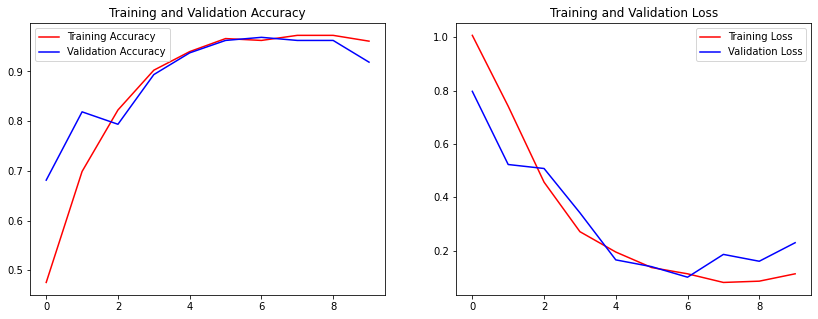

In [14]:
# Melihat perbandingan akurasi dan loss antara test dan validation model dalam Grafik Plot 
  
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
acc_plot, = plt.plot(epochs, acc, 'r')
val_acc_plot, = plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])

# Loss plot
plt.subplot(1, 2, 2)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
loss_plot, = plt.plot(epochs, loss, 'r')
val_loss_plot, = plt.plot(epochs, val_loss, 'b')
plt.title('Training and Validation Loss')
plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

## **4. Prediksi Model**

Saving 3kVoftgTNdDcvPPY.png to 3kVoftgTNdDcvPPY.png
3kVoftgTNdDcvPPY.png
scissors


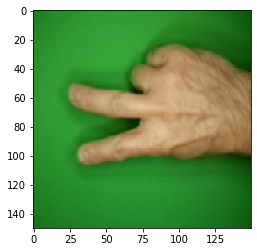

In [15]:
#Mengupload file ke dalam Google Colab 
uploaded = files.upload()

for fn in uploaded.keys():
  #prediksi gambar
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)
  
  print(fn)
  if classes[0,0]!=0:
    print('paper')
  elif classes[0,1]!=0:
    print('rock')
  else:
    print('scissors')